In [1]:
from nd2reader import ND2Reader
%matplotlib inline
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import numpy as np

In [47]:
images = ND2Reader('./20180831_A1_5.nd2')
background = 82
nucleii = images[0]
riboglow = images[1]
halotag = images[2]

def t(threshold_value):
    t_img = halotag > threshold_value
    plt.imshow(t_img)
    plt.show()

slider = widgets.IntSlider(min=0, max=1000, step=10, value=0)
interact(t, threshold_value=slider)

interactive(children=(IntSlider(value=0, description='threshold_value', max=1000, step=10), Output()), _dom_cl…

<function __main__.t(threshold_value)>

In [53]:
#labeled_sg, count = ndi.label(halotag>slider.value)
labeled_sg, count = ndi.label(halotag>900)

print("found {}".format(count))

found 103


In [54]:
# For each label:
# Dilate and xor to obtain pixels around
# apply mask to the Riboglow channel
# get the median of each mask
# make sure that the cell is bead loaded
# get the ratio

ratios = []

for label in range(1,count):
    mask = labeled_sg==label
    dilation = ndi.morphology.binary_dilation(mask, iterations=3) # might have to adjust iterations
    outline = np.logical_xor(dilation,mask)
    rg_sg_mask = np.ma.array(riboglow, mask=np.invert(mask))
    rg_outline_mask = np.ma.array(riboglow, mask=np.invert(outline))
    sg_median = np.ma.median(rg_sg_mask)
    outline_median = np.ma.median(rg_outline_mask)
    if (sg_median<3*background) or (outline_median<3*background): continue
    ratios.append(sg_median/outline_median)

In [55]:
print(len(ratios))
print(np.mean(ratios))

71
1.2173601099263234


cool. now look at a negative control

In [67]:
images = ND2Reader('./20180831_neg1_6_2.nd2')
background = 36
nucleii = images[0]
riboglow = images[1]
halotag = images[2]

def t(threshold_value):
    t_img = halotag > threshold_value
    plt.imshow(t_img)
    plt.show()

slider = widgets.IntSlider(min=0, max=1000, step=10, value=0)
interact(t, threshold_value=slider)

interactive(children=(IntSlider(value=0, description='threshold_value', max=1000, step=10), Output()), _dom_cl…

<function __main__.t(threshold_value)>

In [68]:
#labeled_sg, count = ndi.label(halotag>slider.value)
labeled_sg, count = ndi.label(halotag>700)

print("found {}".format(count))

found 64


In [69]:
# For each label:
# Dilate and xor to obtain pixels around
# apply mask to the Riboglow channel
# get the median of each mask
# make sure that the cell is bead loaded
# get the ratio

ratios_neg = []

for label in range(1,count):
    mask = labeled_sg==label
    dilation = ndi.morphology.binary_dilation(mask, iterations=3) # might have to adjust iterations
    outline = np.logical_xor(dilation,mask)
    rg_sg_mask = np.ma.array(riboglow, mask=np.invert(mask))
    rg_outline_mask = np.ma.array(riboglow, mask=np.invert(outline))
    sg_median = np.ma.median(rg_sg_mask)
    outline_median = np.ma.median(rg_outline_mask)
    if (sg_median<3*background) or (outline_median<3*background): continue
    ratios_neg.append(sg_median/outline_median)

In [70]:
print(len(ratios_neg))
print(np.mean(ratios_neg))

45
1.157799009828825


In [71]:
# from profile_tools.py
import seaborn as sn

def boxplot(df):
        ax = sn.stripplot(data=df,y='ratio',x='condition',jitter=True)
        return sn.boxplot(data=df,y='ratio',x='condition',ax=ax,color='w',fliersize=0)

In [72]:
import pandas as pd

ratio_col = ratios+ratios_neg
condition_col = ['pos' for element in ratios]+['neg' for element in ratios_neg]

df = pd.DataFrame({'ratio':ratio_col,'condition':condition_col})

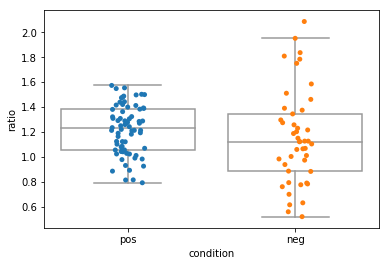

In [73]:
boxplot(df)

Needed to add some lines that verified that the cell was actually loaded with probe. Could I use this on the large images? would that only require one background?

Worth also going in the other direction to look at false positives? Threshold the riboglow channel and look for resolution in the halotag channel? Or just use pearssons?

In [74]:
def find_threshold(img, halochannel=2):
    halotag = img[halochannel]

    def t(threshold_value):
        t_img = halotag > threshold_value
        plt.imshow(t_img)
        plt.show()

    slider = widgets.IntSlider(min=0, max=1000, step=10, value=0)
    interact(t, threshold_value=slider)
    return slider.value

In [ ]:
def find_granules(img, threshold):
    labeled_sg, count = ndi.label(halotag>700)
    print("found {}".format(count))